In [2]:
#%pip install findspark
#%pip install pyspark
#%pip install imblearn

In [1]:
## python 3.8.8
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

# Spark entry point
spark = SparkSession \
    .builder \
    .appName("EDA-pkdd99-xpeMBA") \
    .getOrCreate()

spark.version


'3.0.0'

In [3]:
import os
import pyspark
import pyspark.sql.utils
from pyspark.sql import functions as f
from pyspark.sql import window as w
from pyspark.sql import types as t
from datetime import timedelta
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn import metrics
#from imblearn.over_sampling import SMOTE
#from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
#from sklearn.linear_model import LogisticRegression
#import pickle


Esses notebooks mostram o trabalho de EDA que fiz para me familiarizar com o conjunto de dados e criar algumas visualizações básicas nos recursos extraídos.
Para as parcelas, as verdes (esquerda) correspondem a empréstimos bons e as vermelhas correspondem a empréstimos ruins (inadimplência) se definirmos default como aqueles empréstimos com status de B ou D.

In [6]:

def read_df_asc(tabela=str):
    """
    Função para as bases de dados onde retorna no print o 'shape', um breve 'show' e o Scheema das variáveis.
    :param entidade_name: string que referencie o nome da tabela que complete o caminho './original_data/{tabela}.asc'. 
    tabela pode ser => account, card, client, disp, district, loan, order 
    :return: DataFrame em pyspark
    """
    df = spark.read.csv(path = f'./{tabela}.asc', header='True',inferSchema='False', sep=';')
    print('\n','A base de dados possui:',df.count(), 'linhas', 'e', len(df.columns), 'colunas', '\n')
    print(df.show(5))
    print(df.printSchema())
    return(df)

In [7]:
loan_df = read_df_asc('loan')


 A base de dados possui: 682 linhas e 7 colunas 

+-------+----------+------+------+--------+--------+------+
|loan_id|account_id|  date|amount|duration|payments|status|
+-------+----------+------+------+--------+--------+------+
|   5314|      1787|930705| 96396|      12| 8033.00|     B|
|   5316|      1801|930711|165960|      36| 4610.00|     A|
|   6863|      9188|930728|127080|      60| 2118.00|     A|
|   5325|      1843|930803|105804|      36| 2939.00|     A|
|   7240|     11013|930906|274740|      60| 4579.00|     A|
+-------+----------+------+------+--------+--------+------+
only showing top 5 rows

None
root
 |-- loan_id: string (nullable = true)
 |-- account_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- payments: string (nullable = true)
 |-- status: string (nullable = true)

None


In [8]:
loan_df1 = (
    loan_df
    .withColumnRenamed("date", "date_loan")
    )
loan_df1.show(truncate=False)

+-------+----------+----------+------+--------+--------+------+
|loan_id|account_id|date_loan |amount|duration|payments|status|
+-------+----------+----------+------+--------+--------+------+
|5314   |1787      |1993-07-05|96396 |12      |8033.0  |B     |
|5316   |1801      |1993-07-11|165960|36      |4610.0  |A     |
|6863   |9188      |1993-07-28|127080|60      |2118.0  |A     |
|5325   |1843      |1993-08-03|105804|36      |2939.0  |A     |
|7240   |11013     |1993-09-06|274740|60      |4579.0  |A     |
|6687   |8261      |1993-09-13|87840 |24      |3660.0  |A     |
|7284   |11265     |1993-09-15|52788 |12      |4399.0  |A     |
|6111   |5428      |1993-09-24|174744|24      |7281.0  |B     |
|7235   |10973     |1993-10-13|154416|48      |3217.0  |A     |
|5997   |4894      |1993-11-04|117024|24      |4876.0  |A     |
|7121   |10364     |1993-11-10|21924 |36      |609.0   |A     |
|6077   |5270      |1993-11-22|79608 |24      |3317.0  |A     |
|6228   |6034      |1993-12-01|464520|60

In [8]:
account_df = read_df_asc('account')


 A base de dados possui: 4500 linhas e 4 colunas 

+----------+-----------+----------------+------+
|account_id|district_id|       frequency|  date|
+----------+-----------+----------------+------+
|       576|         55|POPLATEK MESICNE|930101|
|      3818|         74|POPLATEK MESICNE|930101|
|       704|         55|POPLATEK MESICNE|930101|
|      2378|         16|POPLATEK MESICNE|930101|
|      2632|         24|POPLATEK MESICNE|930102|
+----------+-----------+----------------+------+
only showing top 5 rows

None
root
 |-- account_id: string (nullable = true)
 |-- district_id: string (nullable = true)
 |-- frequency: string (nullable = true)
 |-- date: string (nullable = true)

None


In [10]:
account_df1 =(
    account_df
    .withColumnRenamed("date", "date_account")
)
account_df1.show(truncate=False)

+----------+-----------+--------+------------+
|account_id|district_id|stmt_frq|date_account|
+----------+-----------+--------+------------+
|576       |55         |monthly |1993-01-01  |
|3818      |74         |monthly |1993-01-01  |
|704       |55         |monthly |1993-01-01  |
|2378      |16         |monthly |1993-01-01  |
|2632      |24         |monthly |1993-01-02  |
|1972      |77         |monthly |1993-01-02  |
|1539      |1          |after_tr|1993-01-03  |
|793       |47         |monthly |1993-01-03  |
|2484      |74         |monthly |1993-01-03  |
|1695      |76         |monthly |1993-01-03  |
|1726      |48         |monthly |1993-01-03  |
|2881      |70         |monthly |1993-01-04  |
|2357      |19         |monthly |1993-01-04  |
|2177      |62         |monthly |1993-01-04  |
|485       |6          |after_tr|1993-01-04  |
|652       |21         |monthly |1993-01-05  |
|9635      |70         |monthly |1993-01-05  |
|1844      |44         |monthly |1993-01-06  |
|1926      |3

## Loan and Account

* 606 good loans and 76 bad
* Features extracted:
   - loan amount
   - loan duration
   - loan payment
   - account district id
   - frequency
   - date loan issued
   - date account opened
   - days between

In [11]:
print(loan_df1.count())
print(account_df1.count())

682
4500


In [12]:
df = account_df1.join(loan_df1, on="account_id", how="inner")
df = df.withColumn("days_between", f.datediff("date_loan", "date_account"))


In [13]:
df.select('days_between').summary().show()

+-------+------------------+
|summary|      days_between|
+-------+------------------+
|  count|               682|
|   mean|398.24046920821115|
| stddev| 164.6113589799098|
|    min|               102|
|    25%|               261|
|    50%|               395|
|    75%|               529|
|    max|               697|
+-------+------------------+



In [14]:
df.show()

+----------+-----------+--------+------------+-------+----------+------+--------+--------+------+------------+
|account_id|district_id|stmt_frq|date_account|loan_id| date_loan|amount|duration|payments|status|days_between|
+----------+-----------+--------+------------+-------+----------+------+--------+--------+------+------------+
|      5270|         44| monthly|  1993-01-13|   6077|1993-11-22| 79608|      24|  3317.0|     A|         313|
|     11265|         15| monthly|  1993-01-14|   7284|1993-09-15| 52788|      12|  4399.0|     A|         244|
|     10364|         55| monthly|  1993-01-17|   7121|1993-11-10| 21924|      36|   609.0|     A|         297|
|      3834|         54| monthly|  1993-01-19|   5754|1994-09-28| 23052|      12|  1921.0|     A|         617|
|      9307|         68| monthly|  1993-01-24|   6895|1994-09-19| 41904|      12|  3492.0|     A|         603|
|      5891|         54| monthly|  1993-01-25|   6202|1994-04-18| 65184|      12|  5432.0|     A|         448|
|

## Definição de bom e mau

In [15]:
df_good = df.filter((f.col("status") == "A") | (f.col("status") == "C"))
df_bad = df.filter((f.col("status") == "B") | (f.col("status") == "D"))

In [16]:
print(df_good.count())
print(df_bad.count())

606
76


In [17]:
df_bad.show(5)

+----------+-----------+--------+------------+-------+----------+------+--------+--------+------+------------+
|account_id|district_id|stmt_frq|date_account|loan_id| date_loan|amount|duration|payments|status|days_between|
+----------+-----------+--------+------------+-------+----------+------+--------+--------+------+------------+
|      6473|         12| monthly|  1993-01-26|   6316|1994-05-26| 76908|      12|  6409.0|     B|         485|
|      6034|          6|  weekly|  1993-03-19|   6228|1993-12-01|464520|      60|  7742.0|     B|         257|
|      5442|         34| monthly|  1993-03-22|   6112|1994-06-17|174744|      24|  7281.0|     B|         452|
|      1787|         30|  weekly|  1993-03-22|   5314|1993-07-05| 96396|      12|  8033.0|     B|         105|
|      3678|          1| monthly|  1993-03-24|   5724|1995-02-05|316140|      60|  5269.0|     D|         683|
+----------+-----------+--------+------------+-------+----------+------+--------+--------+------+------------+
o

## Análise Gráfica

In [18]:
df_good_pd = df_good.toPandas()
df_bad_pd = df_bad.toPandas()

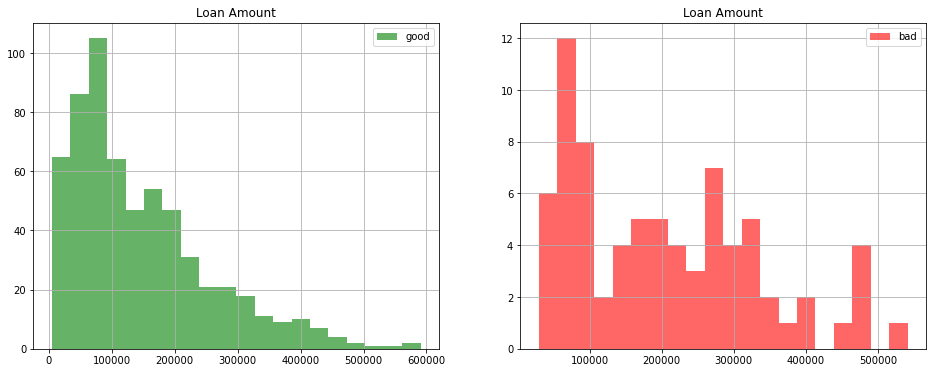

In [19]:
# Amount

df_good_pd['amount'] = pd.to_numeric(df_good_pd['amount'])
df_bad_pd['amount'] = pd.to_numeric(df_bad_pd['amount'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good_pd.amount.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad_pd.amount.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
ax1.set_title('Loan Amount')
ax2.set_title('Loan Amount')
ax1.legend()
ax2.legend()
plt.show()

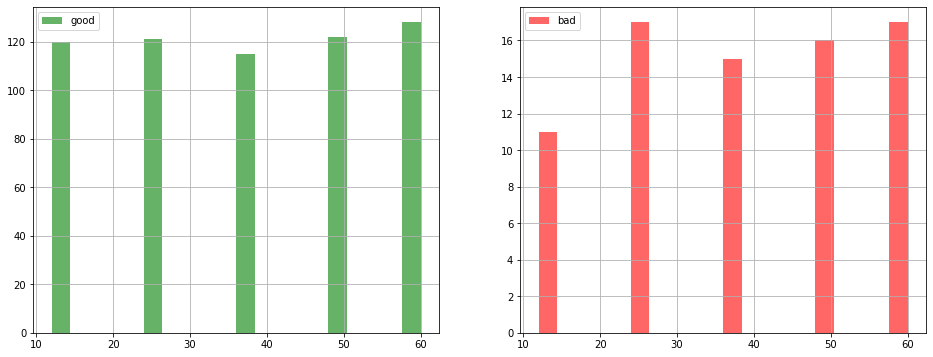

In [20]:
# duration

df_good_pd['duration'] = pd.to_numeric(df_good_pd['duration'])
df_bad_pd['duration'] = pd.to_numeric(df_bad_pd['duration'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good_pd.duration.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad_pd.duration.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
ax1.legend()
ax2.legend()
plt.show()

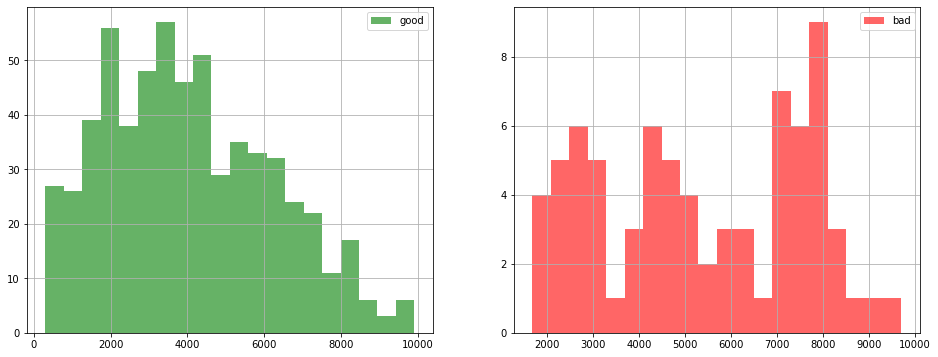

In [21]:
# payments

df_good_pd['payments'] = pd.to_numeric(df_good_pd['payments'])
df_bad_pd['payments'] = pd.to_numeric(df_bad_pd['payments'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good_pd.payments.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad_pd.payments.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
ax1.legend()
ax2.legend()
plt.show()

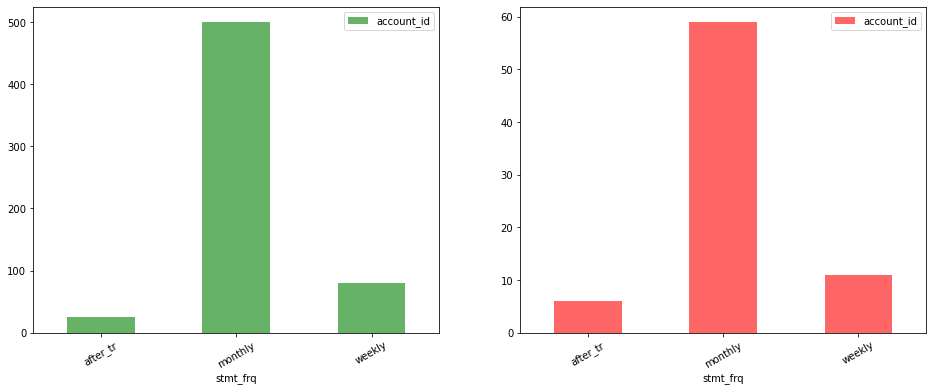

In [22]:
# frequency

##
df_good_pd['payments'] = pd.to_numeric(df_good_pd['payments'])
df_bad_pd['payments'] = pd.to_numeric(df_bad_pd['payments'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good_pd[['account_id', 'stmt_frq']].groupby('stmt_frq').count().plot(kind='bar', color='green', rot=30, ax=ax1, alpha=0.6, legend=False)
df_bad_pd[['account_id', 'stmt_frq']].groupby('stmt_frq').count().plot(kind='bar', color='red', rot=30, ax=ax2, alpha=0.6, legend=False)
ax1.legend()
ax2.legend()
plt.show()

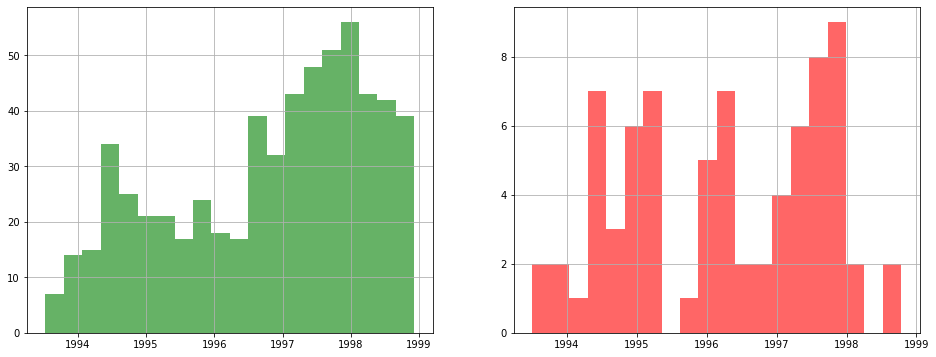

In [24]:
# date loan issued
df_good_pd['date_loan'] = pd.to_datetime(df_good_pd.date_loan, format='%Y-%m-%d')
df_bad_pd['date_loan'] = pd.to_datetime(df_bad_pd.date_loan, format='%Y-%m-%d')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good_pd.date_loan.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad_pd.date_loan.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

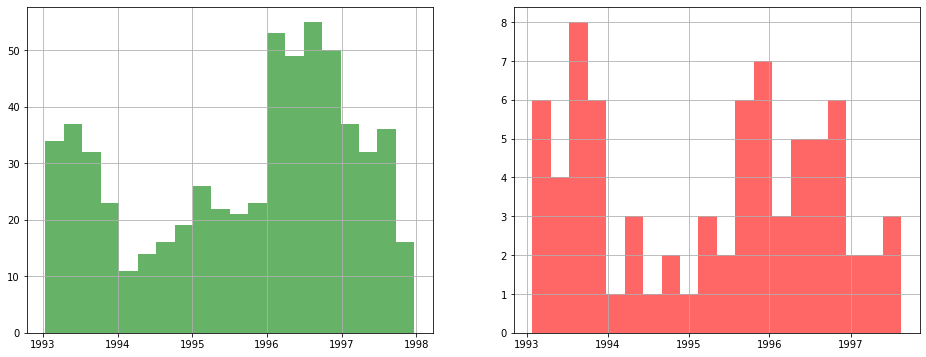

In [26]:
# date account opened

df_good_pd['date_account'] = pd.to_datetime(df_good_pd.date_account, format='%Y-%m-%d')
df_bad_pd['date_account'] = pd.to_datetime(df_bad_pd.date_account, format='%Y-%m-%d')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good_pd.date_account.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad_pd.date_account.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
plt.show()

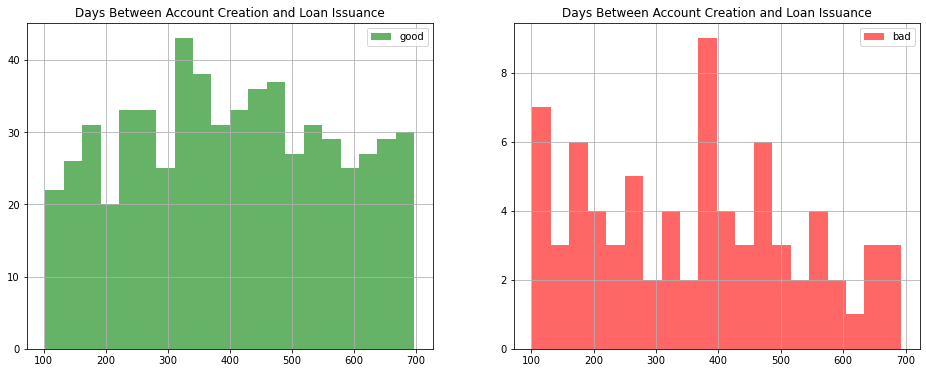

In [29]:
# days_between
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_good_pd.days_between.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
df_bad_pd.days_between.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
ax1.set_title('Days Between Account Creation and Loan Issuance')
ax2.set_title('Days Between Account Creation and Loan Issuance')
ax1.legend()
ax2.legend()
plt.show()